### Problema
La empresa puede estar comprando demasiado de algunos productos que casi no se venden y poco de los que más se venden.

---

### Solucion
La solución propuesta consiste en implementar un sistema de análisis de datos que permita:
- Identificar los productos más vendidos y los que permanecen estancados en el inventario.  
- Analizar la frecuencia de compra y las ciudades o regiones con mayor concentración de ventas.  
- Generar alertas y recomendaciones automáticas para reorganizar el inventario, optimizar las compras y reducir pérdidas económicas.

--- 

### Análisis de la Base de Datos
A partir de la base de datos otorgada, se realizó la limpieza y una mejor estructura: 
- **Tabla Cliente**
    Completamente correcta, sin datos duplicados.
- **Tabla Producto**
    A partir de la columna categoria se realizo una nueva tabla llamada ```Categoria``` con las columnas: ```id_categoria``` y ```nombre_categoria```, a continuación se realizó la conexión con la tabla Producto a partir del id_categoria
- **Tabla Ventas**
    Se eliminaron las columnas ```nombre_cliente```, ```email``` y ```medio_pago```. La columna```medio pago``` paso a ser una nueva tabla, en la cual contiene ```id_medio_pago``` y ```nombre_medio_pago```.
- **Tabla Detalles_ventas**
    Se eliminaron las columnas ```nombre_producto``` y  ```precio_unitario```.

Las tablas con las que nos quedamos son: ```Cliente```, ```Producto```, ```Ventas```, ```Detalles_ventas```, ```Categoria``` y ```Metodo_Pago```.


In [19]:
# Importando Librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Leer datos de todas las tablas
df_clientes = pd.read_csv('data/Clientes.csv')               # Tabla Clientes
df_ventas = pd.read_csv('data/Ventas.csv')                   # Tabla Ventas
df_productos = pd.read_csv('data/Productos.csv')             # Tabla Productos
df_detalle_ventas = pd.read_csv('data/Detalle_ventas.csv')   # Tabla Detalle_Ventas
df_categoria = pd.read_csv('data/Categorias.csv')            # Tabla Categoria
df_metodos_pago = pd.read_csv('data/Metodo_Pago.csv')        # Tabla Metodos_de_Pago

In [24]:
# Estadistica descriptiva inicial de los productos más vendidos
most_sold_products = df_detalle_ventas['id_producto'].value_counts().head(10)
print("Productos más vendidos:")
print(most_sold_products)
# Uniendo tablas para análisis más profundo
detalle_ventas_con_cliente = df_detalle_ventas.merge(df_ventas, on='id_venta') \
                                               .merge(df_clientes, on='id_cliente') \
                                               .merge(df_productos, on='id_producto')
# Estadística descriptiva del importe de las ventas
print("\nEstadísticas descriptivas del importe de las ventas:")
print(detalle_ventas_con_cliente['importe'].describe())

Productos más vendidos:
id_producto
18    9
53    7
72    7
91    7
43    7
38    7
59    6
68    6
28    6
13    6
Name: count, dtype: int64

Estadísticas descriptivas del importe de las ventas:
count      343.000000
mean      7730.078717
std       5265.543077
min        272.000000
25%       3489.000000
50%       6702.000000
75%      10231.500000
max      24865.000000
Name: importe, dtype: float64


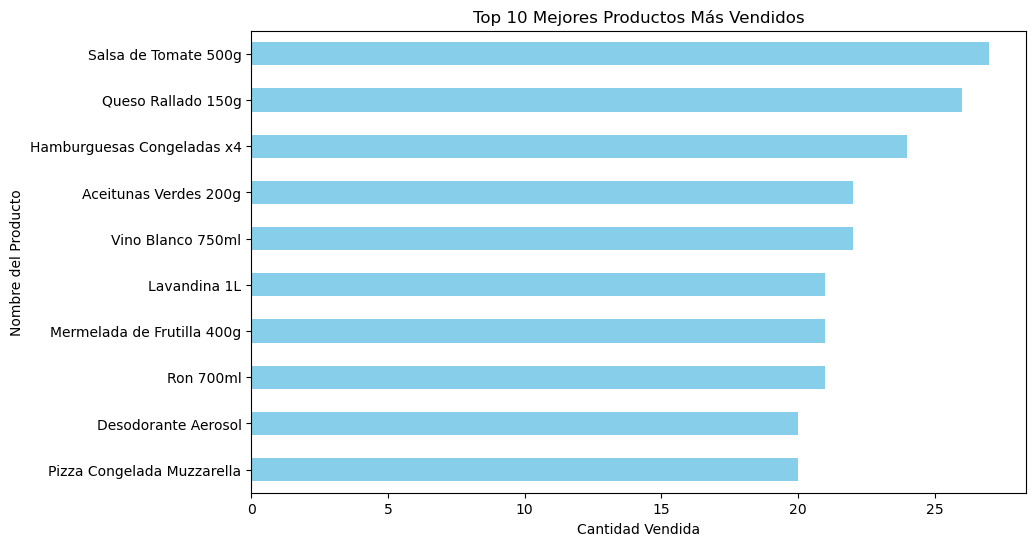

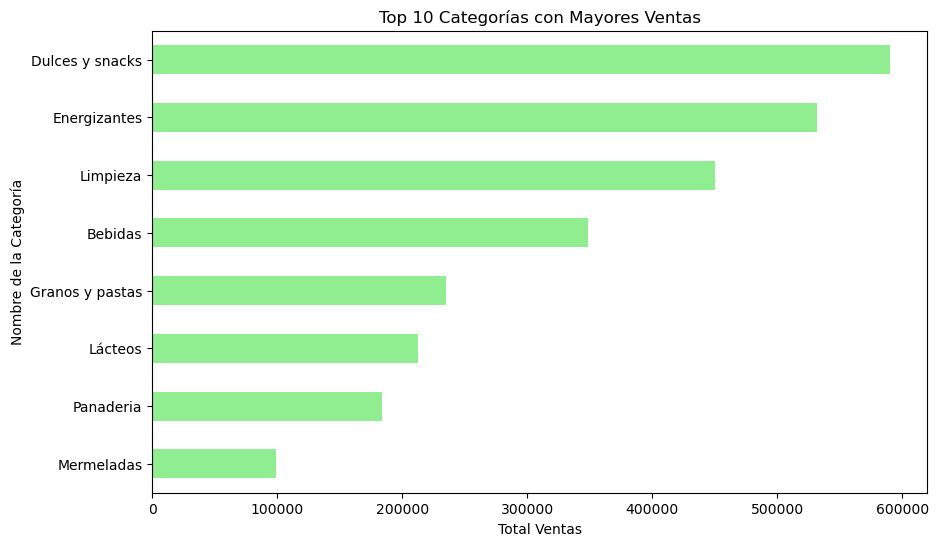

In [10]:
# Unir tablas para análisis
df_ventas_productos = df_detalle_ventas.merge(
    df_ventas, on='id_venta', how='left'
).merge(
    df_productos, on='id_producto', how='left'
)

# Top 10 mejores productos mas vendidos. Eje x: cantidad vendida, eje y: nombre del producto
top_productos = df_ventas_productos.groupby('nombre_producto')['cantidad'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
top_productos.plot(kind='barh', color='skyblue')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Nombre del Producto')
plt.title('Top 10 Mejores Productos Más Vendidos')
plt.gca().invert_yaxis()  # Invertir el eje y para que el
plt.show()

# Top 10 categorias con mayores ventas. Eje x: total ventas, eje y: nombre de la categoria
df_ventas_productos = df_ventas_productos.merge(
    df_categoria, on='id_categoria', how='left')
top_categorias = df_ventas_productos.groupby('nombre_categoria')['importe'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
top_categorias.plot(kind='barh', color='lightgreen')
plt.xlabel('Total Ventas')
plt.ylabel('Nombre de la Categoría')
plt.title('Top 10 Categorías con Mayores Ventas')
plt.gca().invert_yaxis() 
plt.show()


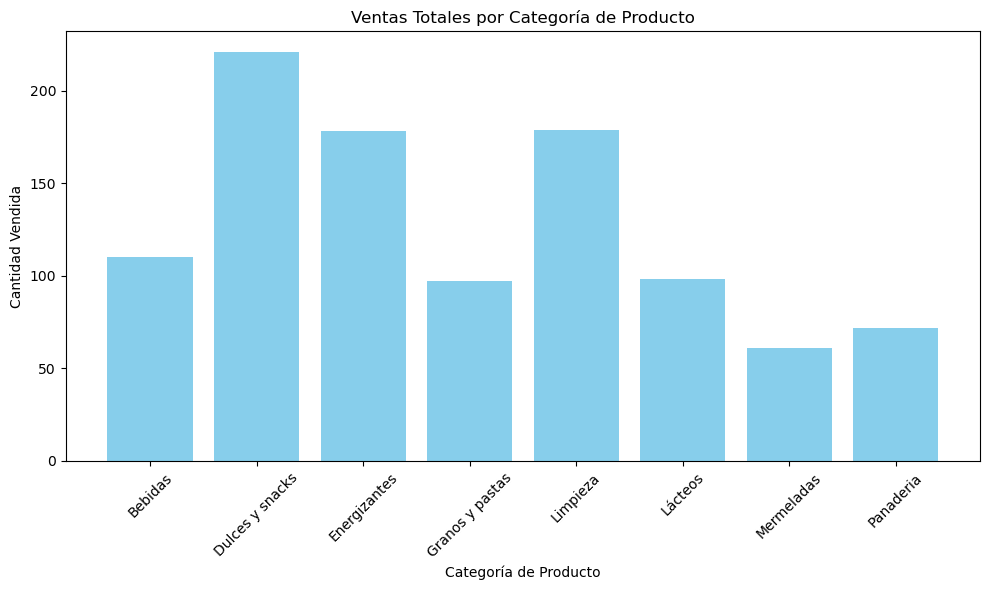

In [12]:

detalle_ventas_con_cliente = df_detalle_ventas.merge(
    df_ventas, on='id_venta', how='left'
).merge(
    df_clientes, on='id_cliente', how='left'
).merge(
    df_productos, on='id_producto', how='left'
).merge(
    df_categoria, on="id_categoria", how='left'
)
#print(detalle_ventas_con_cliente.head())
# Análisis: Ventas totales por categoría de producto
ventas_por_categoria = detalle_ventas_con_cliente.groupby('nombre_categoria')['cantidad'].sum().reset_index()
#print(ventas_por_categoria)
# Visualización: Ventas por categoría
plt.figure(figsize=(10, 6))
plt.bar(ventas_por_categoria['nombre_categoria'], ventas_por_categoria['cantidad'], color='skyblue')
plt.xlabel('Categoría de Producto')
plt.ylabel('Cantidad Vendida')
plt.title('Ventas Totales por Categoría de Producto')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

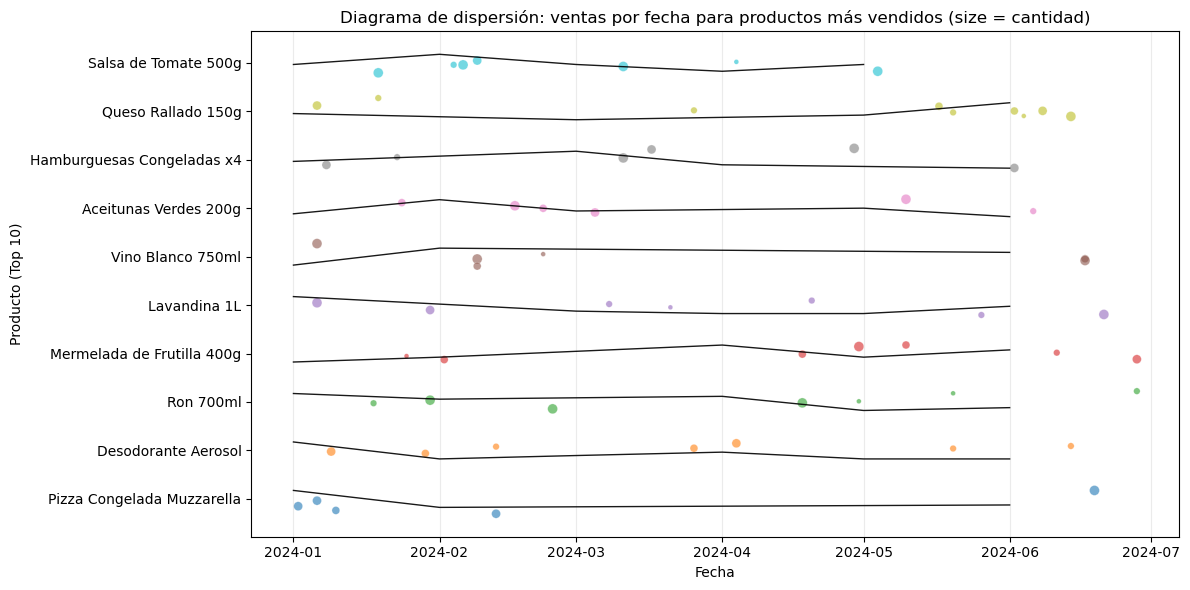

In [20]:
# Diagrama de dispersión de la fecha con respecto a los productos (top N)
# Usamos `detalle_ventas_con_cliente` que contiene `fecha`, `nombre_producto` y `cantidad`

# Preparar datos
detalle = detalle_ventas_con_cliente.copy()
# Intentar normalizar/parsear la columna de fecha (ajusta el nombre si tu columna es distinta)
if 'fecha' in detalle.columns:
    detalle['fecha'] = pd.to_datetime(detalle['fecha'], errors='coerce')
else:
    # Si la columna tiene otro nombre, descomenta y ajusta: detalle['fecha'] = pd.to_datetime(detalle['fecha_venta'])
    raise KeyError('No se encontró la columna "fecha" en `detalle_ventas_con_cliente`.')
# Filtrar filas válidas
detalle = detalle.dropna(subset=['fecha', 'nombre_producto'])
# Seleccionar top N productos por cantidad total para claridad en la visualización
top_n = 10
top_products = detalle.groupby('nombre_producto')['cantidad'].sum().nlargest(top_n).index.tolist()
detalle_top = detalle[detalle['nombre_producto'].isin(top_products)].copy()
# Mapear productos a posiciones numéricas para el eje Y (ordenados para lectura)
productos = list(top_products[::-1])
pos_map = {p: i for i, p in enumerate(productos)}
detalle_top['y_pos'] = detalle_top['nombre_producto'].map(pos_map)
# Añadir pequeño 'jitter' aleatorio en Y para evitar sobreposición
np.random.seed(0)
detalle_top['y_jitter'] = detalle_top['y_pos'] + (np.random.randn(len(detalle_top)) * 0.12)
# Dibujar scatter: X=fecha, Y=producto (jitter), tamaño = cantidad
plt.figure(figsize=(12, 6))
sizes = (detalle_top['cantidad'].fillna(1).astype(float)) ** 0.9  # escalar tamaños
plt.scatter(detalle_top['fecha'], detalle_top['y_jitter'], s=sizes * 12,
            c=detalle_top['y_pos'], cmap='tab10', alpha=0.6, edgecolor='w', linewidth=0.3)
plt.yticks(list(range(len(productos))), productos)
plt.xlabel('Fecha')
plt.ylabel(f'Producto (Top {top_n})')
plt.title('Diagrama de dispersión: ventas por fecha para productos más vendidos (size = cantidad)')
plt.grid(axis='x', alpha=0.25)
# Preparar y superponer líneas de tendencia mensuales para cada producto (normalizadas)
detalle_top['month'] = detalle_top['fecha'].dt.to_period('M').dt.to_timestamp()
monthly = detalle_top.groupby(['month', 'nombre_producto'])['cantidad'].sum().reset_index()
for p in productos:
    dfp = monthly[monthly['nombre_producto'] == p].sort_values('month')
    if dfp.empty:
        continue
    # Normalizar la serie para que la línea sea visible alrededor de la posición Y del producto
    q = dfp['cantidad'].astype(float)
    if q.max() - q.min() > 0:
        norm = (q - q.min()) / (q.max() - q.min())
    else:
        norm = q * 0.0
    # Escalar la normalización para que la línea se muestre en un rango pequeño alrededor de y_pos
    amplitude = 0.35
    y_line = pos_map[p] + (norm - 0.5) * amplitude
    plt.plot(dfp['month'], y_line, color='k', linewidth=1, alpha=0.9)
# Mostrar figura
plt.tight_layout()
plt.show()

/tmp/ipykernel_14180/967119130.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([detalle_ventas_con_cliente[detalle_ventas_con_cliente['ciudad']== ciudad]['importe'] for ciudad in ventas_por_ciudad['ciudad']],


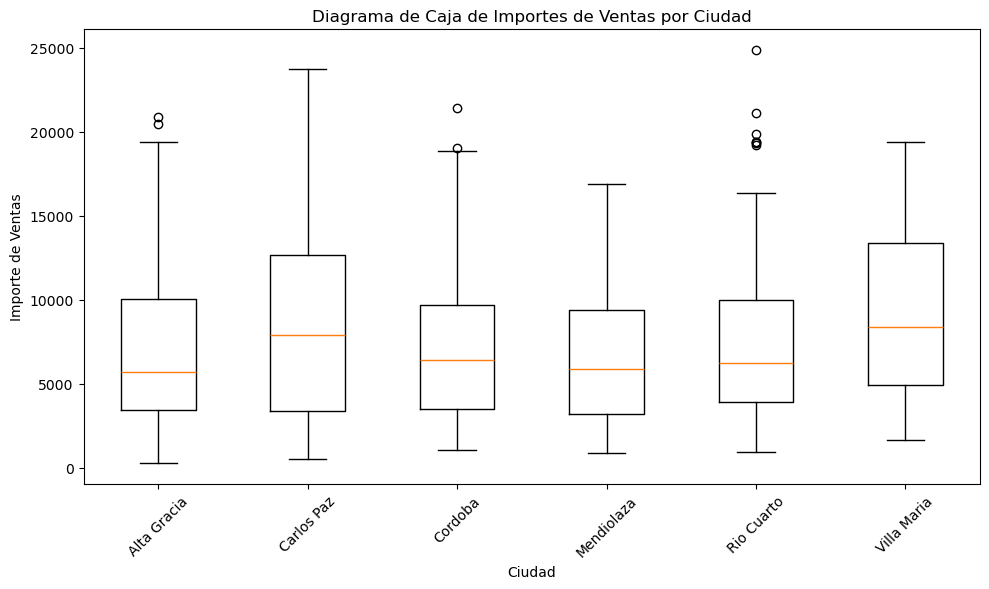

<Figure size 640x480 with 0 Axes>

In [16]:
# Diagrama de caja de las ciudades donde mas se compran productos
ventas_por_ciudad = detalle_ventas_con_cliente.groupby('ciudad')['importe'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.boxplot([detalle_ventas_con_cliente[detalle_ventas_con_cliente['ciudad']== ciudad]['importe'] for ciudad in ventas_por_ciudad['ciudad']],
            labels=ventas_por_ciudad['ciudad'], vert=True)
plt.xlabel('Ciudad')
plt.ylabel('Importe de Ventas')
plt.title('Diagrama de Caja de Importes de Ventas por Ciudad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()      

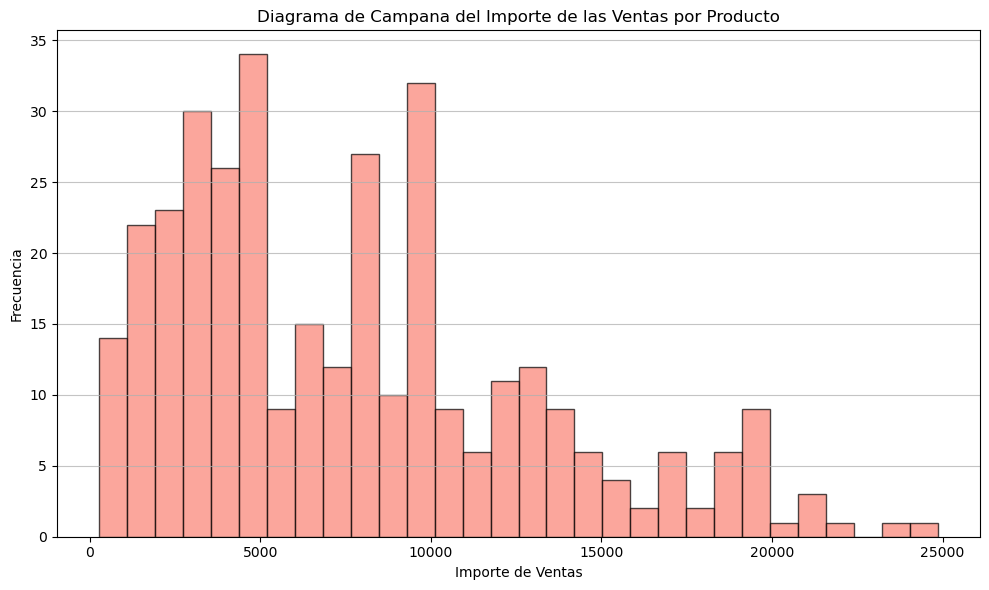

In [25]:
# Diagrama de campana del importe de las ventas por producto
plt.figure(figsize=(10, 6))
plt.hist(detalle_ventas_con_cliente['importe'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
plt.xlabel('Importe de Ventas')
plt.ylabel('Frecuencia')
plt.title('Diagrama de Campana del Importe de las Ventas por Producto')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()  